## Multiclass classifier, but balanced and only 30 classes

Here I move from 2 classes to 30 classes.
 - I had to adapt the model code to support multiclass.
 - I also adapted the model to calculate top10 accuracy and log out the probabilities for each evaluation prediction and auxiliary data to help compute furhter metrics if required.

In the previous binary case the data was kind of balanced already so I dind't have to exactly balance it. Here, I balance the data undersampling to match the number of samples of the least abundant of the 30 classes (which is about 280 samples per label). This undersampling was done somewhat intelligently to avoid 'N' residues in the sequences if possible and to take longer plasmid sequences above desired length to avoid padding. More details below.

I now test the effect of sequence length in 3 different tests:
 - `4_geathirty`: `short`, using sequence length of 100nts (same as before but now 30 classes).
 - `5_gea30long`: `long`, using sequence length of 512nts (this is the maximum that can be passed as input to one model).
 - `6_gea30xl`: `xl`, using sequence length of 1024nts (in this case, the model divides sequence in two of 512 and gets its embeeded representation, and on the last layer concanteates the embedded representations of both subparts and makes a joint prediction. I tried doing 2048 but had memory problems.). 

In all cases, the number of samples in the training and test sets were approximately the same (but in some sequences were longer than in others, obviously). Test set was always 990 samples in total (33 seqs per label) and about 7500 samples in training (aprox 250 seqs per label).

In order to get sequences of different lengths for each I had to sample from the data in different ways. In all cases, I included only 1 sequence per sample. To balance the data I made some data selection and this was different for every case, so it could influence the results somewhat.

 - For the short model, I was able to get 283 samples of each label that had more than 100nts contiguous without any 'N' residues on it. Note that this is not the sampe as randomly sampling from the total of samples for that class. By filtering by size and looking for plasmids that have more than 100nts without any 'N' residues I am biasing the data to good examples, but it is not much.
 - For the long model, I used the same strategy as above. I could get 281 sequences per label. So in total, $30*281$, of which I selected 990 (33 per label) for test data, which is the one used to compare the models.
 - For the xl model, it was much harder to get 1024 nucleotide sequences satisfying these constraints. If possible, I used the same constraints, take 281 samples for each label that at least have 1024 nucleotides without any undefined nucleotides (Ns). If this was not possible, I discarded all sequences with more than 10 undefined nucleotides, and for the ones that remained I converted any possible 'N' to an 'A'. If now it was possible to get a 1024 nucleotide sample, I got it. If it was not possible, I just took the full sequence of the plasmid and padded it. So in order of priority it was: Long and no undefined > Long and some undefined > Shorter and padded and some undefined.

In any cases, the sequence was reverse complemented with probability 0.5. 

The models take very different times to train and to do evaluations, as longer sequences take more time. Also, the ratio of time inverted in training vs time inverted in evaluating is also important for the overall training time.

**Warning**: Normally models are compared by using a shared set of test data. In this case, I am am processing each input sequence differently and sampling of the overall examples to get balanced classes in biased ways so the test data is not exactly the same. Hence, the comparisions between models are subject to changes and this should be considered when interpreting the results.

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# custom functions
sys.path.append('/home/mexposit/cg/gea/transformers/trans_utils')
from analysis_utils import read_scores_from_eval

To identify which score is which I have to read lines 464-468 of the run_finetune.py script, which basically sorts the scores and I see that the order is the same at which they are printed in the logs. The way each score is computed can also be found in `/home/mexposit/cg/gea/dnabert/src/transformers/data/metrics/__init__.py` at the `acc_f1_mcc_auc_pre_rec` function

The steps at which these metrics are computed are different and they are set in the `logging_steps` flag on the command used to run the finetuning job. Here I set them manually to compute at which step each metric corresponds.

In [2]:
short_path = '/home/mexposit/cg/gea/transformers/4_geathirty/model/ft_4_geathirty/eval_results.txt'
short_sc = read_scores_from_eval(short_path, include_top10acc=True, step_freq=25)
long_path = '/home/mexposit/cg/gea/transformers/5_gea30long/model/ft_5_gea30long/eval_results.txt'
long_sc = read_scores_from_eval(long_path, include_top10acc=True, step_freq=10)
xl_path = '/home/mexposit/cg/gea/transformers/6_gea30xl/model/ft_6_gea30xl/eval_results.txt'
xl_sc = read_scores_from_eval(xl_path, include_top10acc=True, step_freq=10)

In [3]:
all_scores = {
    'short':short_sc,
    'long':long_sc,
    'xl':xl_sc
}

Since classes are balanced, the baseline would be picking 1 of the 30 classes randomly:
 - Accuracy baseline=0.033, there is a 1/30 probability to guess it correctly
 - Top10accuracy baseline=0.33, there is a 10/30 prob of guessing it correctly since you can make 10 guesses

In [4]:
acc_baseline = 0.033
top10acc_baseline = 0.3333

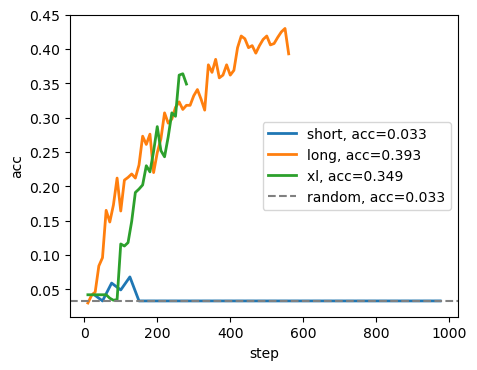

In [5]:
plt.figure(figsize=(5,4), dpi=100)
for name, scs in all_scores.items():
    sns.lineplot(x='step', y='acc', data=scs, lw=2, label=f'{name}, acc={round(scs["acc"].values[-1],3)}')
plt.axhline(acc_baseline, color='gray', lw=1.5, ls='--', label='random, acc=0.033')
plt.legend()
plt.show()

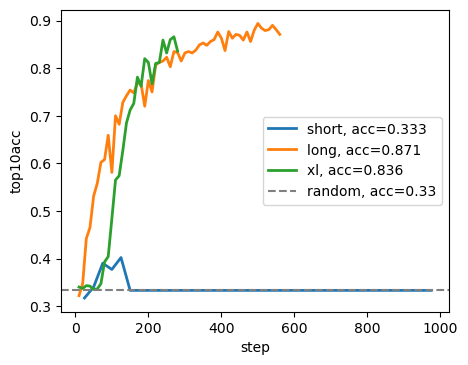

In [6]:
plt.figure(figsize=(5,4), dpi=100)
for name, scs in all_scores.items():
    sns.lineplot(x='step', y='top10acc', data=scs, lw=2, label=f'{name}, acc={round(scs["top10acc"].values[-1],3)}')
plt.axhline(top10acc_baseline, color='gray', lw=1.5, ls='--', label='random, acc=0.33')
plt.legend()
plt.show()

In [7]:
acc_baseline = 0.033
top10acc_baseline = 0.3333

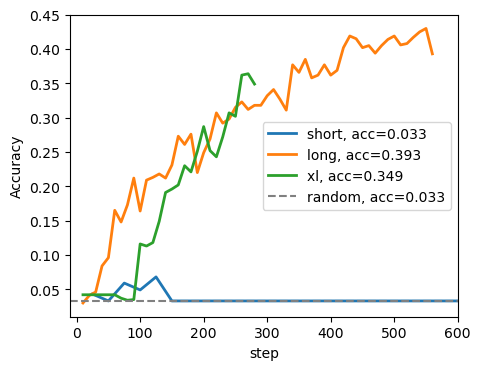

In [8]:
plt.figure(figsize=(5,4), dpi=100)
for name, scs in all_scores.items():
    sns.lineplot(x='step', y='acc', data=scs, lw=2, label=f'{name}, acc={round(scs["acc"].values[-1],3)}')
plt.axhline(acc_baseline, color='gray', lw=1.5, ls='--', label='random, acc=0.033')
plt.xlim(-10, 600)
plt.ylabel('Accuracy')
plt.legend()
plt.show()

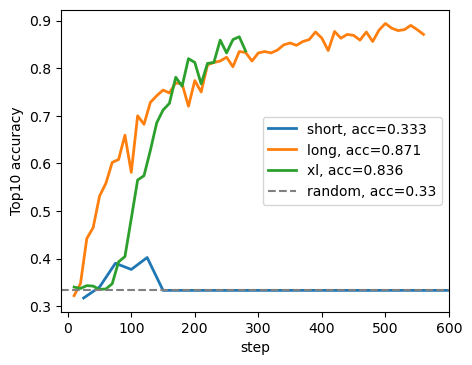

In [9]:
plt.figure(figsize=(5,4), dpi=100)
for name, scs in all_scores.items():
    sns.lineplot(x='step', y='top10acc', data=scs, lw=2, label=f'{name}, acc={round(scs["top10acc"].values[-1],3)}')
plt.axhline(top10acc_baseline, color='gray', lw=1.5, ls='--', label='random, acc=0.33')
plt.xlim(-10, 600)
plt.ylabel('Top10 accuracy')
plt.legend()
plt.show()

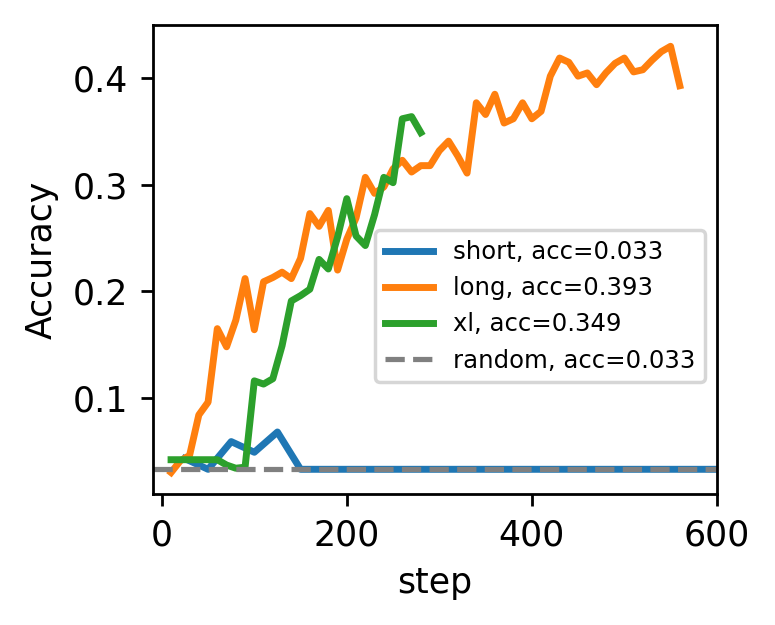

In [10]:
plt.figure(figsize=(3.2,2.6), dpi=250)
for name, scs in all_scores.items():
    sns.lineplot(x='step', y='acc', data=scs, lw=2, label=f'{name}, acc={round(scs["acc"].values[-1],3)}')
plt.axhline(acc_baseline, color='gray', lw=1.5, ls='--', label='random, acc=0.033')
plt.xlim(-10, 600)
plt.ylabel('Accuracy')
plt.legend(loc=5,prop={'size': 7}, bbox_to_anchor=(1,0.4))
plt.tight_layout()
plt.savefig('img_1multicacc.png', dpi=300)
plt.show()

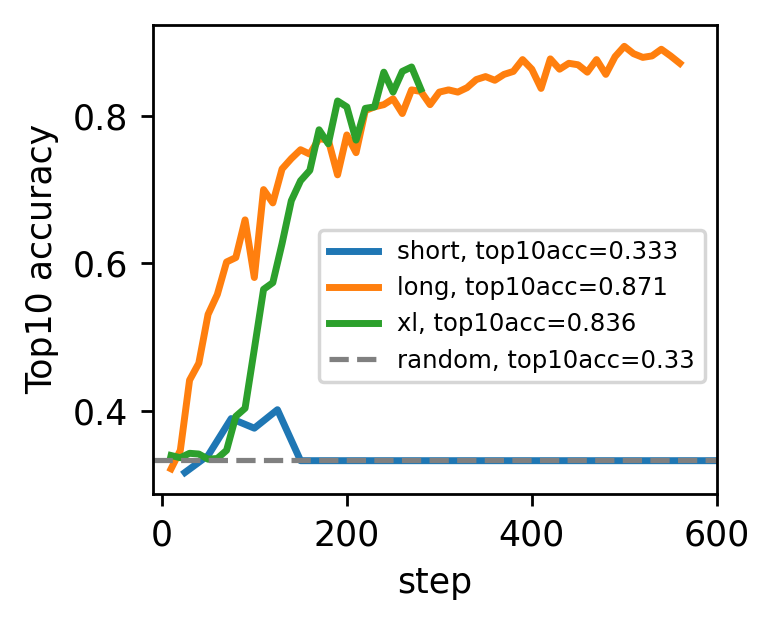

In [11]:
plt.figure(figsize=(3.2,2.6), dpi=250)
for name, scs in all_scores.items():
    sns.lineplot(x='step', y='top10acc', data=scs, lw=2, label=f'{name}, top10acc={round(scs["top10acc"].values[-1],3)}')
plt.axhline(top10acc_baseline, color='gray', lw=1.5, ls='--', label='random, top10acc=0.33')
plt.xlim(-10, 600)
plt.ylabel('Top10 accuracy')
plt.legend(loc=5,prop={'size': 7}, bbox_to_anchor=(1,0.4))
plt.tight_layout()
plt.savefig('img_1multicacctop10.png', dpi=300)
plt.show()

In [12]:
plot_metrics = list(long_sc.columns.values)
plot_metrics.remove('step')

In [13]:
# place top10acc as the third element in the list, not the last
plot_metrics[2], plot_metrics[-1] = plot_metrics[-1], plot_metrics[2]

In [14]:
plot_metrics

['acc', 'auc', 'top10acc', 'mcc', 'precision', 'recall', 'f1']

Conclusions:
 - Model with short sequence (100nts) is not enough to train.
     - Worth reviewing input data to make sure it is correct, as this behavior is unexpected...
     - Worth checking other hyperparameters as the failure to train may be the result of learning rate value
 - Model with long sequence (512nts) shows good progress.
     - Top10accuracy is really good and comparable to competition models, but of course this simplified problem is much easier.
     - Acc increases more in magnitude than top10accuracy, makes sense since we train the model to predict the correct top 1, not top10 in loss.
     - It would be good to leave it training for a longer amount of time until it reaches the top accuracy it can get.
 - Model with extra long sequence (1024) is also in progress of being good.
     - Showed a longer initial phase of start up but now it is increasing faster than the long version of the model.
     - The problem is that it takes twice the amount of time than the 512nts (time increases linearly with length in multiples of 512, as it is literally making two predictions), and since training time is a constraint, it is unlikely that we have enough time to train it enough than the long. In this case, we could say that it can capture more information than the long because it incorporates more sequence information but since it takes longer we get a loss of information it captures as it is not able to look at as many samples and for as many different labels as the long model. So in this compromise between number of samples studied vs amount of information per sample (sequence length) the first seems to be more important in this case and that's why long is better. If training time was not a constraint then the number of samples studied constraint would not be there and XL would likely be better, which could indicate that incorporating even longer sequences could be key to get even higher accuracy.

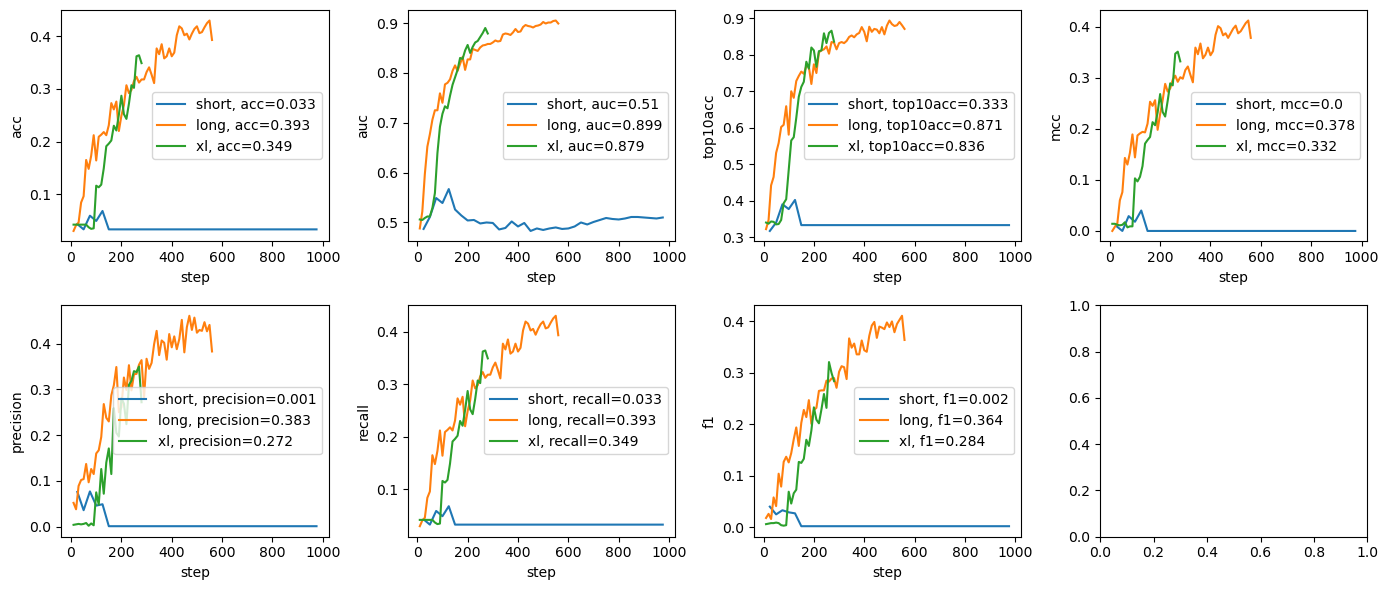

In [15]:
fig, axs = plt.subplots(2, 4, figsize=(14,6), dpi=100)
axs = axs.flatten()

for i, metric in enumerate(plot_metrics):
    for name, scs in all_scores.items():
        sns.lineplot(x='step', y=metric, data=scs, label=f'{name}, {metric}={round(scs[metric].values[-1],3)}', ax=axs[i])
plt.tight_layout()
plt.show()

Look more in detail at 600 first steps

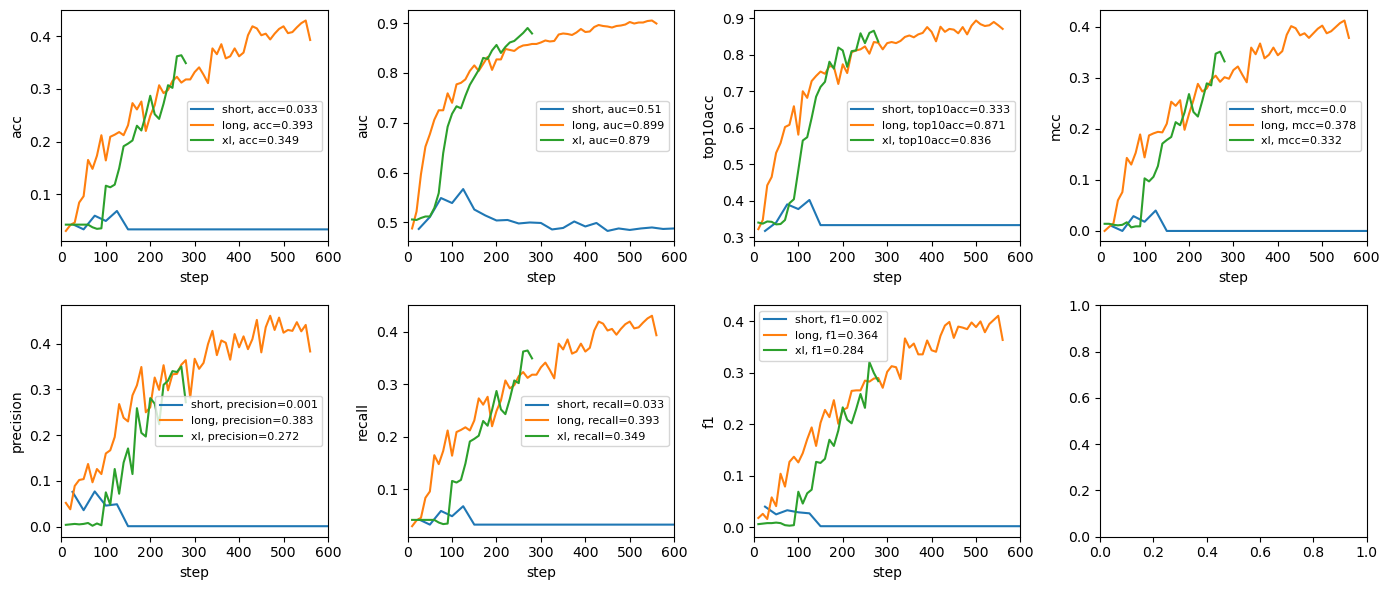

In [16]:
fig, axs = plt.subplots(2, 4, figsize=(14,6), dpi=100)
axs = axs.flatten()

for i, metric in enumerate(plot_metrics):
    for name, scs in all_scores.items():
        sns.lineplot(x='step', y=metric, data=scs, label=f'{name}, {metric}={round(scs[metric].values[-1],3)}', ax=axs[i])
    axs[i].set_xlim(0,600)
    axs[i].legend(prop={'size': 8})
plt.tight_layout()
plt.show()

## ROC multiclass curve for the long 512 model

Using example from `https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html`

In [17]:
from sklearn.metrics import roc_curve, auc

Load the probabilities computed on the test sets.

In [18]:
probs_all = np.load('/home/mexposit/cg/gea/transformers/5_gea30long/model/ft_5_gea30long/eval_probs_results.npy')

Probs keeps the probs of all evaluations on test data, its shape is `(evaluation number, sample, label prob )`

In [19]:
probs_all.shape

(56, 990, 30)

For labels and predictions, since they are only one value (the prediction which is the argmax of the prob, or the correct label), its shape is also a stack of all evaluations and the samples in train set.

In [20]:
label_all = np.load('/home/mexposit/cg/gea/transformers/5_gea30long/model/ft_5_gea30long/eval_label_keys.npy')
preds_all = np.load('/home/mexposit/cg/gea/transformers/5_gea30long/model/ft_5_gea30long/eval_pred_results.npy')
print(label_all.shape)
print(preds_all.shape)

(56, 990)
(56, 990)


There is no really need to keep the labels across evaluations because the samples are always in the same order in the test set.

In [21]:
print(label_all[:,2])
print(label_all[:,4])

[22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 22 22 22]
[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10]


In any case, I will only be looking at the last step and not at the other ones.

In [22]:
probs = probs_all[-1]
label = label_all[-1]
print(probs.shape, label.shape)

(990, 30) (990,)


Sklearn requires the labels to be one hot encoded. Since here the labels identify with one value from 0 to 33, and the probs are returned in this order (with column 0 corresponding to the prob of label zero) it is easy to hot encode the data manually. IMPORTANT: ASSUMES ALL LABELS ARE PRESENT IN THE TEST SET AND IN THE LABEL OBJECT (at least there is one sample for each class).

In [23]:
# demonstrate it with an example
toy_label = np.array([0,0,3,1,4,5,2,2])
lab_categories = np.sort(pd.Series(toy_label).value_counts().index)
label_onehot = np.zeros([len(toy_label), len(lab_categories)])
print(label_onehot.shape)
for i,lab in enumerate(toy_label):
    label_onehot[i, lab] = 1
print(label_onehot)

(8, 6)
[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


In [24]:
# get indices of labels
lab_categories = np.sort(pd.Series(label).value_counts().index)
label_onehot = np.zeros([len(label), len(lab_categories)])
print(label_onehot.shape)
for i,lab in enumerate(label):
    label_onehot[i, lab] = 1
print(label_onehot.shape)
# the number of 1s must be the same as number of label samples
print(np.sum(label_onehot) == len(label))

(990, 30)
(990, 30)
True


Micro is averaging within each sample, macro is giving the same weight to all classes. In this case since classes are balanced it makes sense they are kind of the same. Will take the micro

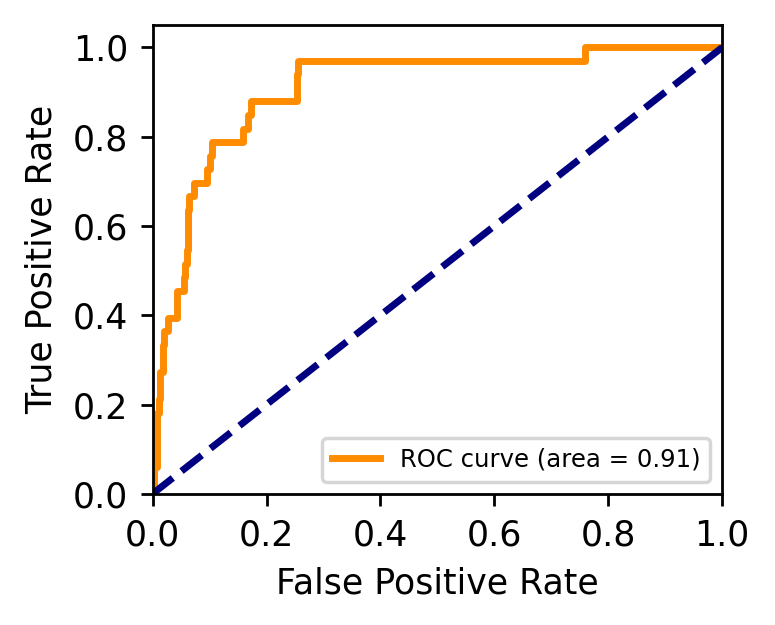

In [25]:
plt.figure(figsize=(3.2,2.6), dpi=250)
# plt.figure(figsize=(4.5,3.5), dpi=100)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(lab_categories)):
    fpr[i], tpr[i], _ = roc_curve(label_onehot[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(label_onehot.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(lab_categories))]))

lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("Receiver operating characteristic")
plt.legend(prop={'size': 7}, loc="lower right")
plt.tight_layout()
plt.savefig('img_1auc512.png', dpi=300)
plt.show()

Plotting micro, macro and the individual curves per each of the 30 classes

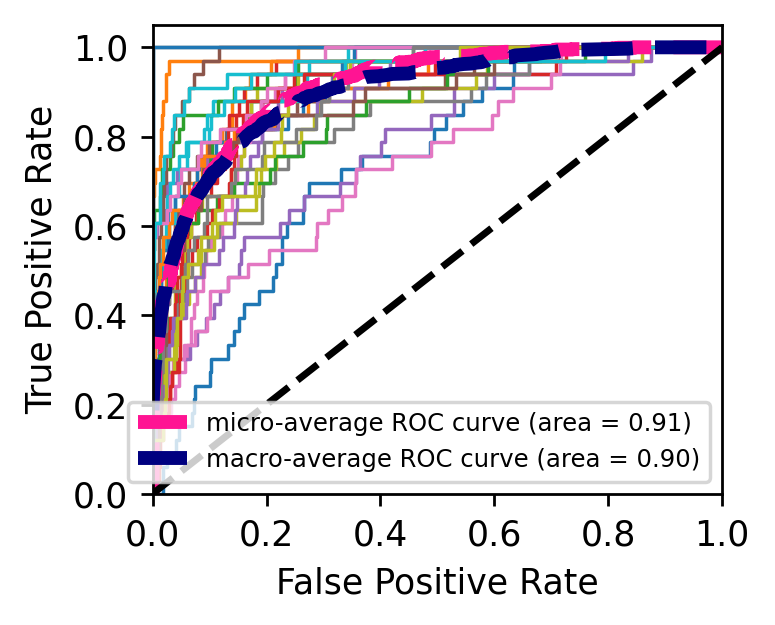

In [26]:
plt.figure(figsize=(3.2,2.6), dpi=250)
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(lab_categories)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(lab_categories)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
for i in range(len(lab_categories)):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=1,
#         label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle="--",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle="--",
    linewidth=4,
)

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(prop={'size': 7}, loc="lower right")
plt.tight_layout()
plt.savefig('img_1auc512multic.png', dpi=300)
plt.show()

AUC distribution by class

In [27]:
auc_by_class = [roc_auc[i] for i in range(0,30)]

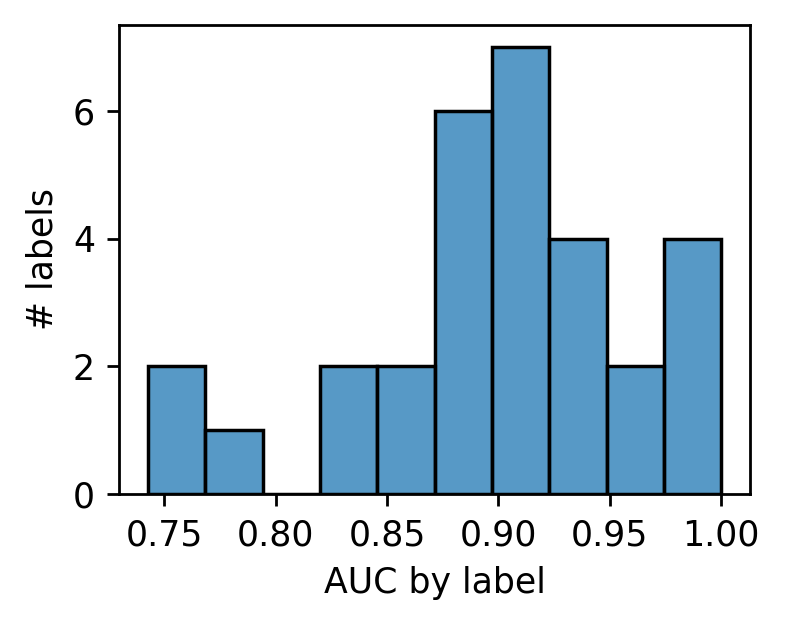

In [28]:
# plt.figure(figsize=(5,3), dpi=200)
plt.figure(figsize=(3.2,2.6), dpi=250)
sns.histplot(auc_by_class, bins=10)
plt.xlabel('AUC by label')
plt.ylabel('# labels')
plt.tight_layout()
plt.savefig('img_1auc512aucdist.png', dpi=300)
plt.show()

Print the classes with lowest AUC, might be interesting to study them.

In [29]:
_ = [print(f'Class {i}: AUC={round(roc_auc[i],3)}') for i in range(0,30) if (roc_auc[i] < 0.8)]

Class 0: AUC=0.743
Class 14: AUC=0.781
Class 16: AUC=0.745


## ROC multiclass curve for the XL 1024 model

Using example from `https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html`

In [30]:
from sklearn.metrics import roc_curve, auc

Load the probabilities computed on the test sets.

In [31]:
probs_all = np.load('/home/mexposit/cg/gea/transformers/6_gea30xl/model/ft_6_gea30xl/eval_probs_results.npy')

Probs keeps the probs of all evaluations on test data, its shape is `(evaluation number, sample, label prob )`

In [32]:
probs_all.shape

(28, 990, 30)

For labels and predictions, since they are only one value (the prediction which is the argmax of the prob, or the correct label), its shape is also a stack of all evaluations and the samples in train set.

In [33]:
label_all = np.load('/home/mexposit/cg/gea/transformers/6_gea30xl/model/ft_6_gea30xl/eval_label_keys.npy')
preds_all = np.load('/home/mexposit/cg/gea/transformers/6_gea30xl/model/ft_6_gea30xl/eval_pred_results.npy')
print(label_all.shape)
print(preds_all.shape)

(28, 990)
(28, 990)


There is no really need to keep the labels across evaluations because the samples are always in the same order in the test set.

In [34]:
print(label_all[:,2])
print(label_all[:,4])

[22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22]
[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10]


In any case, I will only be looking at the last step and not at the other ones.

In [35]:
probs = probs_all[-1]
label = label_all[-1]
print(probs.shape, label.shape)

(990, 30) (990,)


Sklearn requires the labels to be one hot encoded. Since here the labels identify with one value from 0 to 33, and the probs are returned in this order (with column 0 corresponding to the prob of label zero) it is easy to hot encode the data manually. IMPORTANT: ASSUMES ALL LABELS ARE PRESENT IN THE TEST SET AND IN THE LABEL OBJECT (at least there is one sample for each class).

In [36]:
# demonstrate it with an example
toy_label = np.array([0,0,3,1,4,5,2,2])
lab_categories = np.sort(pd.Series(toy_label).value_counts().index)
label_onehot = np.zeros([len(toy_label), len(lab_categories)])
print(label_onehot.shape)
for i,lab in enumerate(toy_label):
    label_onehot[i, lab] = 1
print(label_onehot)

(8, 6)
[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


In [37]:
# get indices of labels
lab_categories = np.sort(pd.Series(label).value_counts().index)
label_onehot = np.zeros([len(label), len(lab_categories)])
print(label_onehot.shape)
for i,lab in enumerate(label):
    label_onehot[i, lab] = 1
print(label_onehot.shape)
# the number of 1s must be the same as number of label samples
print(np.sum(label_onehot) == len(label))

(990, 30)
(990, 30)
True


Micro is averaging within each sample, macro is giving the same weight to all classes. In this case since classes are balanced it makes sense they are kind of the same. Will take the micro

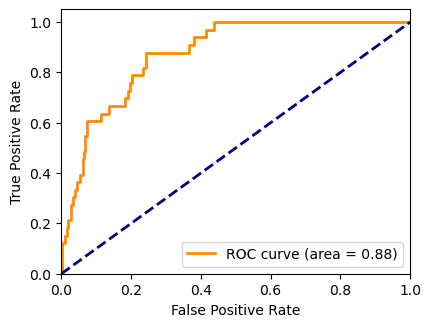

In [38]:
plt.figure(figsize=(4.5,3.5), dpi=100)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(lab_categories)):
    fpr[i], tpr[i], _ = roc_curve(label_onehot[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(label_onehot.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(lab_categories))]))

lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

Plotting micro, macro and the individual curves per each of the 30 classes

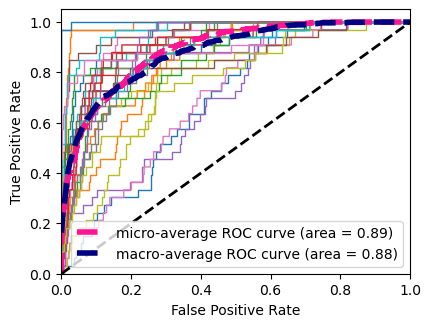

In [39]:
plt.figure(figsize=(4.5,3.5), dpi=100)
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(lab_categories)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(lab_categories)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
for i in range(len(lab_categories)):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=1,
#         label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle="--",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle="--",
    linewidth=4,
)

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

AUC distribution by class

In [40]:
auc_by_class = [roc_auc[i] for i in range(0,30)]

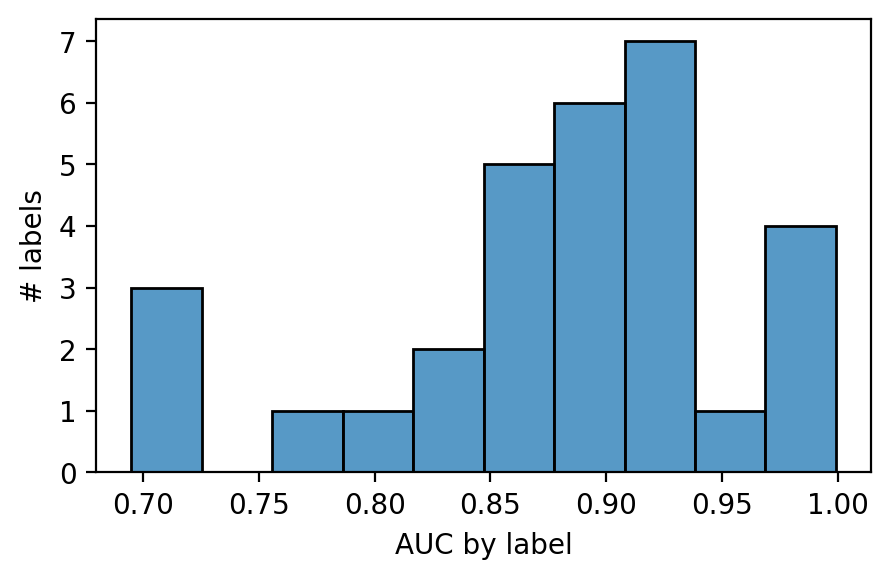

In [41]:
plt.figure(figsize=(5,3), dpi=200)
sns.histplot(auc_by_class, bins=10)
plt.xlabel('AUC by label')
plt.ylabel('# labels')
plt.show()

Print the classes with lowest AUC, might be interesting to study them.

In [42]:
_ = [print(f'Class {i}: AUC={round(roc_auc[i],3)}') for i in range(0,30) if (roc_auc[i] < 0.8)]

Class 0: AUC=0.695
Class 14: AUC=0.703
Class 16: AUC=0.7
Class 18: AUC=0.792
Class 28: AUC=0.781
